# Introduction
In homework assignment 3, we will implement the soft actor critic (SAC) algorithm to solve a classic rocket trajectory optimization problem--Lunar Lander v2

# Enabling and testing the GPU

First, you may need to enable GPUs for this notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with pytorch:

In [1]:
import torch
import os
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Found device at: {}'.format(device))

Found device at: cuda:0


# Install gym environment

In [2]:
!pip install swig
!pip install gymnasium[box2d]

# Load tensorboard for visualizing

In [3]:
%load_ext tensorboard

# Import required package

In [4]:
import torch.nn as nn
from math import pi as pi_constant
from typing import Tuple
from collections import namedtuple
from collections import deque
import numpy.random as nr

import numpy as np
import gymnasium as gym
from torch.utils.tensorboard import SummaryWriter

import datetime
import copy
import torch.nn.functional as F

Tensor = torch.DoubleTensor
torch.set_default_tensor_type(Tensor)
Transitions = namedtuple('Transitions', ['obs', 'action', 'reward', 'next_obs', 'done'])

E:\UCR_Projects\RLProject\RLenv\lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


# Replay buffer

In [5]:
class ReplayBuffer(nn.Module):
    def __init__(self, config):
        super().__init__()
        replay_buffer_size = config['replay_buffer_size']
        seed = config['seed']
        self.device = config['device']
        nr.seed(seed)

        self.replay_buffer_size = replay_buffer_size
        self.obs = deque([], maxlen=self.replay_buffer_size)
        self.action = deque([], maxlen=self.replay_buffer_size)
        self.reward = deque([], maxlen=self.replay_buffer_size)
        self.next_obs = deque([], maxlen=self.replay_buffer_size)
        self.done = deque([], maxlen=self.replay_buffer_size)

    def append_memory(self,
                      obs,
                      action,
                      reward,
                      next_obs,
                      done: bool):
        self.obs.append(obs)
        self.action.append(action)
        self.reward.append(reward)
        self.next_obs.append(next_obs)
        self.done.append(done)

    def sample(self, batch_size):
        buffer_size = len(self.obs)

        idx = nr.choice(buffer_size,
                        size=min(buffer_size, batch_size),
                        replace=False)
        t = Transitions
        t.obs = torch.stack(list(map(self.obs.__getitem__, idx))).to(self.device)
        t.action = torch.stack(list(map(self.action.__getitem__, idx))).to(self.device)
        t.reward = torch.stack(list(map(self.reward.__getitem__, idx))).to(self.device)
        t.next_obs = torch.stack(list(map(self.next_obs.__getitem__, idx))).to(self.device)
        t.done = torch.tensor(list(map(self.done.__getitem__, idx)))[:, None].to(self.device)
        return t

    def clear(self):
        self.obs = deque([], maxlen=self.replay_buffer_size)
        self.action = deque([], maxlen=self.replay_buffer_size)
        self.reward = deque([], maxlen=self.replay_buffer_size)
        self.next_obs = deque([], maxlen=self.replay_buffer_size)
        self.done = deque([], maxlen=self.replay_buffer_size)

# Actor network

In [6]:
class ActorNet(nn.Module):
    def __init__(self,
                 device,
                 dim_obs: int,
                 dim_action: int,
                 dims_hidden_neurons: Tuple[int] = (64, 64)):
        super(ActorNet, self).__init__()
        self.n_layers = len(dims_hidden_neurons)
        self.dim_action = dim_action
        self.device = device

        self.ln2pi = torch.log(Tensor([2*pi_constant]))

        n_neurons = (dim_obs,) + dims_hidden_neurons + (dim_action,)
        for i, (dim_in, dim_out) in enumerate(zip(n_neurons[:-2], n_neurons[1:-1])):
            layer = nn.Linear(dim_in, dim_out).double()
            # nn.Linear: input: (batch_size, n_feature)
            #            output: (batch_size, n_output)
            torch.nn.init.xavier_uniform_(layer.weight)
            torch.nn.init.zeros_(layer.bias)
            exec('self.layer{} = layer'.format(i + 1))  # exec(str): execute a short program written in the str

        self.output_mu = nn.Linear(n_neurons[-2], n_neurons[-1]).double()
        torch.nn.init.xavier_uniform_(self.output_mu.weight)
        torch.nn.init.zeros_(self.output_mu.bias)

        self.output_logsig = nn.Linear(n_neurons[-2], n_neurons[-1]).double()
        torch.nn.init.xavier_uniform_(self.output_logsig.weight)
        torch.nn.init.zeros_(self.output_logsig.bias)

    def forward(self, obs: torch.Tensor):
        x = obs
        for i in range(self.n_layers):
            x = eval('torch.relu(self.layer{}(x))'.format(i + 1))
        mu = self.output_mu(x)
        sig = torch.exp(self.output_logsig(x))

        # for the log probability under tanh-squashed Gaussian, see Appendix C of the SAC paper
        u = mu + sig * torch.normal(torch.zeros(size=mu.shape), 1).to(self.device)
        a = torch.tanh(u)
        logProbu = -1/2 * (torch.sum(torch.log(sig**2), dim=1, keepdims=True).to(self.device) +
                           torch.sum((u-mu)**2/sig**2, dim=1, keepdims=True) +
                           a.shape[1]*self.ln2pi.to(self.device))
        logProba = logProbu - torch.sum(torch.log(1 - a ** 2 + 0.000001), dim=1, keepdims=True)
        return a, logProba, torch.tanh(mu)

# Critic network

In [7]:
class QCriticNet(nn.Module):
    def __init__(self,
                 dim_obs: int,
                 dim_action: int,
                 dims_hidden_neurons: Tuple[int] = (64, 64)):
        super(QCriticNet, self).__init__()
        self.n_layers = len(dims_hidden_neurons)
        self.dim_action = dim_action

        n_neurons = (dim_obs + dim_action,) + dims_hidden_neurons + (1,)
        for i, (dim_in, dim_out) in enumerate(zip(n_neurons[:-2], n_neurons[1:-1])):
            layer = nn.Linear(dim_in, dim_out).double()
            # nn.Linear: input: (batch_size, n_feature)
            #            output: (batch_size, n_output)
            torch.nn.init.xavier_uniform_(layer.weight)
            torch.nn.init.zeros_(layer.bias)
            exec('self.layer{} = layer'.format(i + 1))  # exec(str): execute a short program written in the str

        self.output = nn.Linear(n_neurons[-2], n_neurons[-1]).double()
        torch.nn.init.xavier_uniform_(self.output.weight)
        torch.nn.init.zeros_(self.output.bias)

    def forward(self, obs: torch.Tensor, action: torch.Tensor):
        x = torch.cat((obs, action), dim=1)
        for i in range(self.n_layers):
            x = eval('torch.relu(self.layer{}(x))'.format(i + 1))
        return self.output(x)

#SAC agent
The base code are given in this section. The updates of the actor and critic networks are missing and are left out for you to fill. You may refer to the SAC paper https://arxiv.org/pdf/1801.01290.pdf or Spinning up tutorial for SAC https://spinningup.openai.com/en/latest/algorithms/sac.html

## SAC Algorithm Update Function Overview

The update function is integral to the Soft Actor-Critic (SAC) algorithm, managing the iterative update of both actor and critic networks. It utilizes a sampled batch from the replay buffer to facilitate network training. This buffer contains sequences of states, actions, rewards, next states, and termination flags, essential for the training of the SAC model.

### Critics Update Process

The update begins with sampling actions for the next states using the actor network. These actions, along with their log probabilities, are used to compute the Q values from the target critic networks. The objective is to calculate the minimum Q value adjusted by the entropy term, which is crucial for the entropy-augmented objective of SAC. This computed Q value serves as the target for updating the current critic networks. The loss for each critic is calculated as the mean squared error between the predicted Q values and the computed target Q values. These losses are used to perform a gradient update on each critic network independently.

### Actor Update Process

Parallel to the critic update, the actor network is also updated. This involves computing the Q values for the current states and the new actions proposed by the actor network. The actor's loss is computed as the negative of the minimum of these Q values adjusted by the entropy term, promoting exploration. This loss facilitates the gradient update of the actor network, aligning the policy more closely with the performance criterion of maximizing expected return plus entropy.

### Target Networks Soft Update

Finally, the target critic networks are softly updated to slowly track the learned networks. This is achieved by linearly interpolating between the parameters of the target networks and the learned networks using a smoothing coefficient. This technique helps to stabilize the learning process by providing consistent target values for the training of the critic networks.

In summary, the SAC's update function methodically adjusts the parameters of both actor and critic networks using backpropagation based on the computed losses and ensures stability and consistency in learning through the soft updates of the target networks.


In [8]:
class SAC(nn.Module):
    def __init__(self, config):
        super(SAC,self).__init__()
        torch.manual_seed(config['seed'])

        self.lr = config['lr']  # learning rate
        self.smooth = config['smooth']  # smoothing coefficient for target net
        self.discount = config['discount']  # discount factor
        self.alpha = config['alpha']  # temperature parameter in SAC
        self.batch_size = config['batch_size']  # mini batch size

        self.dims_hidden_neurons = config['dims_hidden_neurons']
        self.dim_obs = config['dim_obs']
        self.dim_action = config['dim_action']

        self.device = config['device']

        self.actor = ActorNet(device=config['device'],
                              dim_obs=self.dim_obs,
                              dim_action=self.dim_action,
                              dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)
        self.Q1 = QCriticNet(dim_obs=self.dim_obs,
                             dim_action=self.dim_action,
                             dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)
        self.Q2 = QCriticNet(dim_obs=self.dim_obs,
                             dim_action=self.dim_action,
                             dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)
        self.Q1_tar = QCriticNet(dim_obs=self.dim_obs,
                                 dim_action=self.dim_action,
                                 dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)
        self.Q2_tar = QCriticNet(dim_obs=self.dim_obs,
                                 dim_action=self.dim_action,
                                 dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)

        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.optimizer_Q1 = torch.optim.Adam(self.Q1.parameters(), lr=self.lr)
        self.optimizer_Q2 = torch.optim.Adam(self.Q2.parameters(), lr=self.lr)

    def update(self, buffer):
        # sample from replay memory
        t = buffer.sample(self.batch_size)

        # TO DO: Perform the updates for the actor and critic networks
        (states, actions, rewards, next_states, dones) = (t.obs, t.action, t.reward, t.next_obs, t.done)

        # <--------------- Next Action and Squashed Action --------------->
        next_actions, next_log_pi, a_hat = self.actor(next_states)
        
        # <--------------- Critics --------------->
        # Compute the target Q value
        with torch.no_grad():
            Q1_next_target = self.Q1_tar(next_states, next_actions)
            Q2_next_target = self.Q2_tar(next_states, next_actions)
            min_Q_next_target = torch.min(Q1_next_target, Q2_next_target) - self.alpha * next_log_pi
            Q_target = rewards + (1 - dones.float()) * self.discount * min_Q_next_target

        # Get current Q estimates
        current_Q1 = self.Q1(states, actions)
        current_Q2 = self.Q2(states, actions)
    
        # Compute critic loss
        critic_loss1 = F.mse_loss(current_Q1, Q_target)
        critic_loss2 = F.mse_loss(current_Q2, Q_target)

        # Update critics
        self.optimizer_Q1.zero_grad()
        critic_loss1.backward()
        self.optimizer_Q1.step()
    
        self.optimizer_Q2.zero_grad()
        critic_loss2.backward()
        self.optimizer_Q2.step()

        # <--------------- Actor --------------->
        # Compute actor loss
        Q1_new = self.Q1(states, next_actions)
        Q2_new = self.Q2(states, next_actions)
        Q_new_min = torch.min(Q1_new, Q2_new)
    
        actor_loss = (self.alpha * next_log_pi - Q_new_min).mean()

        # Update actor
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        # <--------------- Target Qs --------------->
        # Update target networks
        for target_param, param in zip(self.Q1_tar.parameters(), self.Q1.parameters()):
                target_param.data.copy_(self.smooth * param.data + (1 - self.smooth) * target_param.data)
            
        for target_param, param in zip(self.Q2_tar.parameters(), self.Q2.parameters()):
            target_param.data.copy_(self.smooth * param.data + (1 - self.smooth) * target_param.data)
        

    def act_probabilistic(self, obs: torch.Tensor):
        self.actor.eval()
        a, logProb, mu = self.actor(obs)
        self.actor.train()
        return a

    def act_deterministic(self, obs: torch.Tensor):
        self.actor.eval()
        a, logProb, mu = self.actor(obs)
        self.actor.train()
        return mu

# Create environment

In [9]:
env = gym.make('LunarLanderContinuous-v2')

config = {
    'dim_obs': 8,
    'dim_action': 2,
    'dims_hidden_neurons': (120, 120),
    'lr': 0.001,
    # 'smooth': 0.99,
    'smooth': 0.001,
    'discount': 0.99,
    'alpha': 0.2,
    'batch_size': 128,
    'replay_buffer_size': 20000,
    'seed':3,
    'max_episode': 700,
    'device':device
}

# Create agent

In [10]:
sac = SAC(config).to(device)
buffer = ReplayBuffer(config)


# train_writer = SummaryWriter(log_dir='tensorboard/sac')
from datetime import datetime
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_dir = f'tensorboard/sac/data_{current_time}_alpha-{config["alpha"]}_batch_size-{config["batch_size"]}_seed-{config["seed"]}'
train_writer = SummaryWriter(log_dir=log_dir)
print(log_dir)

tensorboard/sac/data_2024-05-21_10-38-16_alpha-0.2_batch_size-128_seed-3


# Start training

In [11]:
steps = 0
for i_episode in range(config['max_episode']):
    obs = env.reset()[0]
    done = False
    truncated = False
    t = 0
    ret = 0.
    while done is False and truncated is False:
        # env.render()

        obs_tensor = torch.tensor(obs).type(Tensor).to(device)

        action = sac.act_probabilistic(obs_tensor[None, :]).detach().cpu().numpy()[0, :]
        next_obs, reward, done, truncated,_ = env.step(action)

        buffer.append_memory(obs=obs_tensor,
                             action=torch.from_numpy(action),
                             reward=torch.from_numpy(np.array([reward/10.0])),
                             next_obs=torch.from_numpy(next_obs).type(Tensor),
                             done=done)

        sac.update(buffer)

        t += 1
        steps += 1
        ret += reward

        obs = copy.deepcopy(next_obs)

        if done or truncated:
            print("Episode {} return {}".format(i_episode, ret))
    train_writer.add_scalar('Performance/episodic_return', ret, i_episode)

env.close()
train_writer.close()

Episode 0 return -206.60038153110216
Episode 1 return -303.1441987908307
Episode 2 return -94.38942568735614
Episode 3 return -60.63866805382078
Episode 4 return -88.43336151279543
Episode 5 return -285.7818232818462
Episode 6 return -172.60118171665306
Episode 7 return -333.29862488980206
Episode 8 return -35.70106335344046
Episode 9 return -101.73446153228312
Episode 10 return -110.7165438405132
Episode 11 return -171.85992042457957
Episode 12 return -229.0679798042297
Episode 13 return -457.5684847296645
Episode 14 return -171.45019088439932
Episode 15 return -62.984235830736935
Episode 16 return -126.41388141364556
Episode 17 return -32.28562052761475
Episode 18 return -103.09509089688343
Episode 19 return -311.42991822849655
Episode 20 return -19.26933935658799
Episode 21 return -167.56092194213406
Episode 22 return -133.35434514075394
Episode 23 return 21.79617610026817
Episode 24 return -370.703926364141
Episode 25 return -1.4394417087772524
Episode 26 return 29.94775055308682
E

# visualizing

## SAC Algorithm Performance

The SAC algorithm was run for 700 episodes with two different seeds. The highest reward achieved was approximately 170, with the smoothed value around 100. Below is a plot showing the smoothed version of returns per episode for the two runs. This visualization helps in understanding the consistency and variability of the performance across different initializations.


### Comparison of DDPG and SAC in Terms of Noise in Results

Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC) are both popular reinforcement learning algorithms designed for continuous action spaces. DDPG is known for being more sensitive to hyperparameter settings and experiencing significant variance in its learning curve. This noise primarily stems from DDPG's reliance on deterministic policy updates combined with off-policy learning, which can lead to issues of stability due to the compounding of approximation errors in both the policy and value networks. Furthermore, DDPG's exploration is solely based on adding noise to the action outputs (e.g., Ornstein-Uhlenbeck process), which might not always ensure adequate exploration of the state space.

On the other hand, SAC incorporates entropy regularization into its objective, encouraging the policy to explore more diverse actions. This entropy term not only aids in exploration but also stabilizes the learning process by smoothing over the policy updates. The stochastic nature of the policy in SAC helps in better exploration and mitigates the risk of premature convergence to suboptimal policies, a challenge often faced by DDPG. Given these advantages, SAC generally results in smoother learning curves and more robust policies compared to DDPG. Thus, while DDPG might be simpler to implement and computationally less intensive, SAC's ability to maintain a balance between exploration and exploitation through entropy regularization generally makes it a superior choice for tasks requiring reliable performance in complex environments.


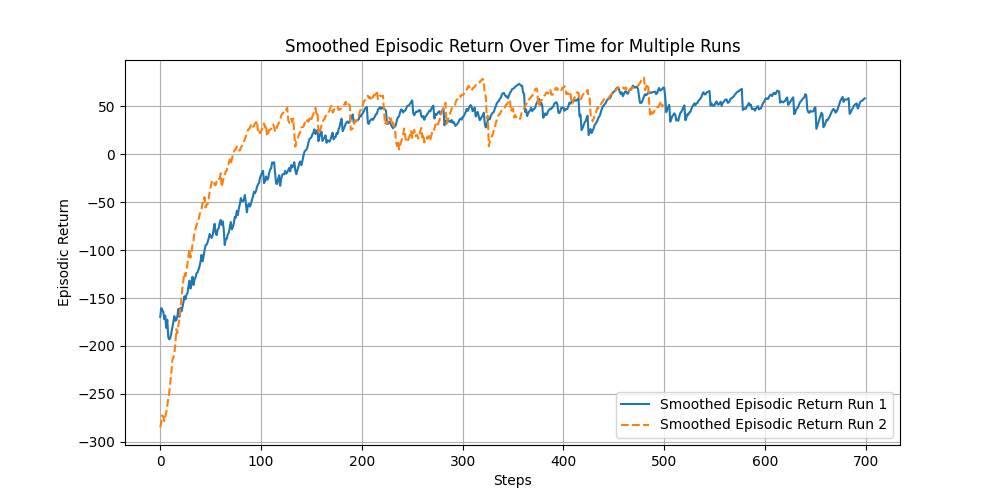

In [46]:
from IPython.display import Image, display

# Replace 'path_to_image.png' with the path to your actual image file
display(Image(filename='SAC_smoothed_episodic_return_comparison.png'))

In [45]:
%tensorboard --logdir='tensorboard/sac'

Reusing TensorBoard on port 6006 (pid 29644), started 4:16:07 ago. (Use '!kill 29644' to kill it.)